In [2]:
import torch
from torch.autograd import Variable


# dataset about y = x ** 2 + sin(x) + 10
# return a tensor dataset
def get_dataset(filepath, num_samples, cols):
    dataset = torch.zeros(num_samples, cols, dtype=torch.float)
    with open(filepath, 'r') as f:
        lines = f.readlines()
        row = 0
        for line in lines:
            datas = line.split(' ')
            # print(len(datas))
            for col in range(cols):
                dataset[row, col] = float(datas[col])
            row += 1
    return dataset


datapath = 'D:\\my_jupyter\\Datasets\\cnn_data\\cnn_data.txt'
labelpath = 'D:\\my_jupyter\\Datasets\\cnn_data\\cnn_label.txt'
num_train = 1000
num_test = 500
cols = 300
x_dataset = get_dataset(datapath, num_train+num_test, cols)
label_dataset = get_dataset(labelpath, num_train+num_test, cols)
x_dataset[0:10], x_dataset.shape, label_dataset[0:10], label_dataset.shape

(tensor([[-4.4236e-01,  3.0754e-03,  2.8951e-02,  ...,  4.6800e+00,
           4.6840e+00,  6.1422e+00],
         [-6.3883e-02,  1.2029e-01,  1.6343e-01,  ...,  4.8334e+00,
           4.9577e+00,  5.0838e+00],
         [-1.0492e-01,  3.7569e-01,  4.7057e-01,  ...,  5.1777e+00,
           5.2942e+00,  5.3588e+00],
         ...,
         [-1.5607e-01,  1.1821e-01,  1.2718e-01,  ...,  4.8570e+00,
           4.9800e+00,  5.0108e+00],
         [-3.1951e-01, -3.1276e-01,  2.0504e-01,  ...,  4.9116e+00,
           4.9306e+00,  5.7954e+00],
         [-3.8061e-01, -1.4772e-01,  2.0171e-01,  ...,  4.7952e+00,
           5.3774e+00,  5.5829e+00]]),
 torch.Size([1500, 300]),
 tensor([[11.8498,  8.9816,  8.8271,  ...,  2.8225,  2.8359,  9.8735],
         [ 9.3874,  8.2927,  8.0461,  ...,  3.3614,  3.8325,  4.3422],
         [ 9.6405,  6.8870,  6.3980,  ...,  4.7424,  5.2632,  5.5641],
         ...,
         [ 9.9608,  8.3047,  8.2531,  ...,  3.4485,  3.9204,  4.0435],
         [11.0192, 10.9744,  7

In [3]:
# generate the real train,test data,shape: (num_train, 1, num_x)..
from random import randint


x_train = x_dataset[0:num_train]
y_train = label_dataset[0:num_train]
x_test = x_dataset[num_train:]
y_test = label_dataset[num_train:]
print(x_train.shape, x_test.shape)

x_train = x_train.view(x_train.shape[0], 1, x_train.shape[1])
y_train = y_train.view(y_train.shape[0], 1, y_train.shape[1])
x_test = x_test.view(x_test.shape[0], 1, x_test.shape[1])
y_test = y_test.view(y_test.shape[0], 1, y_test.shape[1])

x_train.shape, x_test.shape

torch.Size([1000, 300]) torch.Size([500, 300])


(torch.Size([1000, 1, 300]), torch.Size([500, 1, 300]))

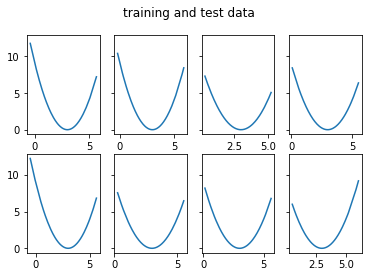

In [4]:
# show the train and test data
import matplotlib.pyplot as plt

number_len = 4
number_samples = [randint(0, x_test.shape[0]-1) for i in range(number_len)]

fig, axs = plt.subplots(2, number_len, sharey=True)
fig.suptitle('training and test data')

for j in range(number_len):
    axs[0][j].plot(x_train[number_samples[j], 0], y_train[number_samples[j], 0])
    axs[1][j].plot(x_test[number_samples[j], 0], y_test[number_samples[j], 0])

plt.show()

In [22]:
# create cnn module
from torch import nn
from random import randint

input_pipe = 1
output_pipe = 60
kernel_size = 300
stride = 1
padding = 149
#(1, 1, 300) -> (1, 60, 299)  (300-k+2*p1+1)/1=299
#(1, 60, 299) -> (1, 1, 300)  (299-k+2*p2+1)/1 = 300  
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(input_pipe, output_pipe, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Conv1d(output_pipe, 1, kernel_size=kernel_size, stride=stride, padding=padding+1),
            nn.ReLU()
        )
    
    def forward(self, x):
        out1 = self.layer1(x)
        out2 = self.layer2(out1)
        return out2

cnn = CNN()
cnn.cuda()

# lr = 0.0003 loss:0.10
# lr = 0.0002 loss:0.07
lr = 0.0002
batch_size = 1
num_epochs = 400
num_batches = x_train.shape[0] // batch_size  # 2000 // bs

loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(cnn.parameters(), lr=lr)

train_loss_list = []
for epoch in range(num_epochs):
    train_loss = 0.0
    for i in range(num_batches):
        pos = randint(0, num_batches-1)
        x = Variable(x_train[pos*batch_size:pos*batch_size+batch_size, :, :]).cuda()
        y_hat = cnn(x)
        y = Variable(y_train[pos*batch_size:pos*batch_size+batch_size, :, :]).cuda()
        
        loss = loss_function(y_hat, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_loss_list.append(loss.item())
    print('epoch:%d, averge train loss:%f' % (epoch, train_loss / num_batches))

epoch:0, averge train loss:1.995276
epoch:1, averge train loss:1.933023
epoch:2, averge train loss:1.900591
epoch:3, averge train loss:1.912630
epoch:4, averge train loss:1.929025
epoch:5, averge train loss:1.885167
epoch:6, averge train loss:1.850540
epoch:7, averge train loss:1.808786
epoch:8, averge train loss:1.845848
epoch:9, averge train loss:1.852224
epoch:10, averge train loss:1.813786
epoch:11, averge train loss:1.799960
epoch:12, averge train loss:1.876284
epoch:13, averge train loss:1.865622
epoch:14, averge train loss:1.853516
epoch:15, averge train loss:1.886414
epoch:16, averge train loss:1.870064
epoch:17, averge train loss:1.877102
epoch:18, averge train loss:1.866586
epoch:19, averge train loss:1.192050
epoch:20, averge train loss:0.260400
epoch:21, averge train loss:0.223997
epoch:22, averge train loss:0.192497
epoch:23, averge train loss:0.182179
epoch:24, averge train loss:0.169130
epoch:25, averge train loss:0.178822
epoch:26, averge train loss:0.171558
epoch:27, a

epoch:219, averge train loss:0.091968
epoch:220, averge train loss:0.084185
epoch:221, averge train loss:0.086312
epoch:222, averge train loss:0.086063
epoch:223, averge train loss:0.087837
epoch:224, averge train loss:0.085804
epoch:225, averge train loss:0.086021
epoch:226, averge train loss:0.082092
epoch:227, averge train loss:0.089061
epoch:228, averge train loss:0.082535
epoch:229, averge train loss:0.086072
epoch:230, averge train loss:0.088520
epoch:231, averge train loss:0.087699
epoch:232, averge train loss:0.082412
epoch:233, averge train loss:0.086295
epoch:234, averge train loss:0.088035
epoch:235, averge train loss:0.087246
epoch:236, averge train loss:0.083508
epoch:237, averge train loss:0.083598
epoch:238, averge train loss:0.084322
epoch:239, averge train loss:0.087360
epoch:240, averge train loss:0.089683
epoch:241, averge train loss:0.081450
epoch:242, averge train loss:0.091072
epoch:243, averge train loss:0.087087
epoch:244, averge train loss:0.085210
epoch:245, a

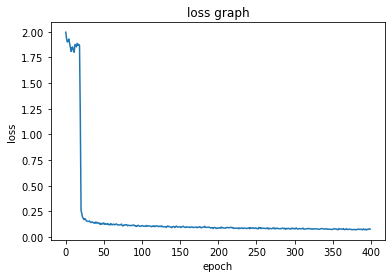

In [27]:
import numpy as np


# draw the loss graph 
def draw_loss_graph(num_epochs, loss_list):
    plt.title('loss graph')
    epochs = np.arange(0, num_epochs)
    a_epoch = len(loss_list) // num_epochs
    loss_list = torch.tensor(loss_list, dtype=torch.float)
    aver_loss = []
    for i in range(num_epochs):
        aver_loss.append(loss_list[i*a_epoch:(i+1)*a_epoch].mean())
    plt.plot(epochs, aver_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
    

draw_loss_graph(num_epochs, train_loss_list)

test averager loss:0.072764
[460, 393, 397, 381]
torch.Size([500, 1, 300]) torch.Size([500, 1, 300]) torch.Size([500, 1, 300])


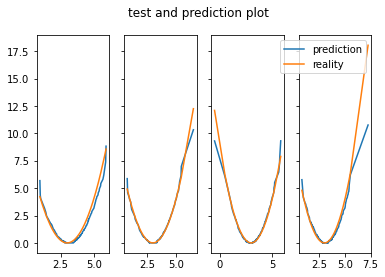

In [36]:
# look test dataset loss and draw the test prediction graph
def draw_test_pred():
    test_loss = 0.0
    x = Variable(x_test[:, :, :]).cuda()
    y_hat = cnn(x)
    y = Variable(y_test[:, :, :]).cuda()
    
    for i in range(x_test.shape[0]):
        loss = loss_function(y_hat[i:i+1, :, :], y[i:i+1, :, :])
        test_loss += loss.item()
    
    test_loss = test_loss / x_test.shape[0]
    print('test averager loss:%f' % (test_loss))
    
    number_len = 4
    no_samples = [randint(0, x_test.shape[0]-1) for i in range(number_len)]
    print(no_samples)
    fig, axs = plt.subplots(1, number_len, sharey=True)
    fig.suptitle('test and prediction plot')
    
    x = x.detach().cpu()
    y_pred = y_hat.detach().cpu()
    y = y.detach().cpu()
    print(x.shape, y_pred.shape, y.shape)
    for i in range(number_len):
        axs[i].plot(x[no_samples[i], 0], y_pred[no_samples[i], 0], label='prediction')
        axs[i].plot(x[no_samples[i], 0], y[no_samples[i], 0], label='reality')
    plt.legend(loc='best')
    plt.show()
    
draw_test_pred()

In [ ]:
'''
1D CNN outputs between layers and input/output
layer1: (1, 1, 300) -> (1, 60, 299)
between inputs and layer:  1x300(X) -> 60x299(H)   H = (60x1)*X*(300x299)+(60x299)     
layer2: (1, 60, 299) -> (1, 1, 300)
between layer and outputs: 60x299(H) -> 1x300(Y)   Y = (1x60)*H*(299x1)+(1x300)

'''